In [1]:
import pandas as pd

df = pd.read_pickle("data_clean.pkl")
dict = {'Real': 0, 'Fake': 1}
df["Type"] = df["Type"].map(dict)
df

,Month,Text,Type
0,"Feb,20",kuala lumpur tourism art culture ministry focu...,0
1,"Feb,20",kuching sarawak record four new patient invest...,0
2,"Feb,20",johor baru police open investigation paper spr...,0
3,"Feb,20",johor baru malaysian love like red red rise bl...,0
4,"Feb,20",petaling jaya one day least love trump even an...,0
...,...,...,...
885,"Nov,20",najib loot rm billion bond epf pas rm billion ...,1
886,"Nov,20",regret inform kelantan state ministry health t...,1
887,"Nov,20",due influence majority malaysian face salary p...,1
888,"Nov,20",oldtown curry noodle restaurant rumor contain ...,1


In [2]:
X = df["Text"].values
y = df["Type"].values

In [3]:
from gensim.models import KeyedVectors

pretrained_word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [4]:
pretrained_word2vec["data"].shape

(300,)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import manifold
from lime import lime_text

import pandas as pd

C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


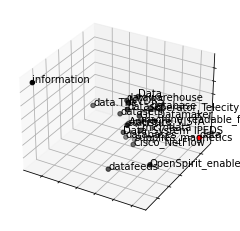

In [6]:
word = "data"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 pretrained_word2vec.most_similar(word, topn=20)]
X = pretrained_word2vec[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [7]:
X = df["Text"].values
y = df["Type"].values

In [105]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [9]:
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq = tokenizer.texts_to_sequences(X)

## padding sequence
from keras.preprocessing.sequence import pad_sequences

maxLen = 150
X_indices = pad_sequences(lst_text2seq, maxlen=maxLen, padding="post")

In [10]:
max_len = len(lst_text2seq)
total = 0
count = 0
for ls in lst_text2seq:
    if len(ls) > max_len:
        max_len = len(ls)
    total += len(ls)
    count += 1
print(f"Largest length of text: {max_len}")
print(f"Average length of text: {total/count}")

Largest length of text: 890
Average length of text: 111.38539325842697


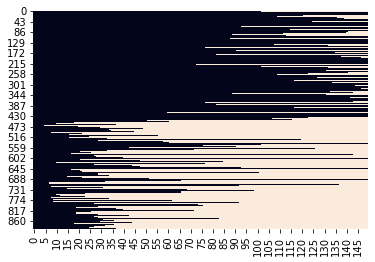

In [12]:
sns.heatmap(X_indices==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [39]:
## create sequence
#X_test_indices = tokenizer.texts_to_sequences(X_test)

## padding sequence
#from keras.preprocessing.sequence import pad_sequences

#maxLen = 150
#X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding="post")

In [13]:
import numpy as np
embeddings = np.zeros((len(dic_vocabulary), 300))

for word, idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] = pretrained_word2vec[word]
    except:
        pass

In [14]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Flatten

feature_extractor = Sequential()
feature_extractor.add(Embedding(input_dim=len(dic_vocabulary), output_dim=300, input_length=maxLen, weights=[embeddings], trainable=False))
feature_extractor.add(Flatten())
#model.add(Dense(1, activation="sigmoid"))

In [129]:
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 300)          3647400   
                                                                 
 flatten_9 (Flatten)         (None, 45000)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 45001     
                                                                 
Total params: 3,692,401
Trainable params: 45,001
Non-trainable params: 3,647,400
_________________________________________________________________
None


In [30]:
from sklearn.naive_bayes import MultinomialNB
mnb_clf = MultinomialNB(alpha=0.84)

from sklearn.svm import SVC
svm_clf = SVC(kernel="rbf", C=9.0, gamma=0.00126)

from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=5)

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)

from sklearn.linear_model import LogisticRegression
log_reg_clf = LogisticRegression(solver="lbfgs", random_state=42, C=96)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=50,
    algorithm="SAMME.R", learning_rate=0.63, random_state=42
)

In [130]:
#from sklearn.model_selection import StratifiedKFold

#kf = StratifiedKFold(n_splits=5)

In [31]:
X_indices.shape

(890, 150)

In [32]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10)

In [35]:
%%time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

np.random.seed(42)

#scores_nn = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}

scores_mnb = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_svm = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_dt = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_rf = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_log_reg = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_ada = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}

lookup_clf = {0:scores_mnb, 1:scores_svm, 2:scores_dt, 3:scores_rf, 4:scores_log_reg, 5:scores_ada}

param_distributions_mnb = {'alpha': np.linspace(0, 2, 20), 'fit_prior': [True, False]}
param_distributions_svm = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
param_distributions_dt = {"max_depth": uniform(5, 30)}
param_distributions_rf = {"n_estimators": np.arange(5, 100)}
param_distributions_log = {"C": uniform(0.01, 100)}
param_distributions_ada = {"learning_rate": uniform(0.1, 2)}

param_distributions = [param_distributions_mnb, param_distributions_svm, param_distributions_dt, param_distributions_rf, param_distributions_log, param_distributions_ada]


for train_index, test_index in kf.split(X_indices, y):
    X_train, X_test, y_train, y_test = X_indices[train_index], X_indices[test_index], y[train_index], y[test_index]
    
    X_train_features = feature_extractor.predict(X_train)
    
    X_test_features = feature_extractor.predict(X_test)
    
    clf_list = [mnb_clf, svm_clf, dt_clf, rf_clf, log_reg_clf, ada_clf]
    
    for index, clf in enumerate(clf_list):
        print(f"Training {clf.__class__.__name__}")
        
        if index == 0:
            X_train_features = np.abs(X_train_features)
            X_test_features = np.abs(X_test_features)
        elif index == 1:
            X_train_features = feature_extractor.predict(X_train)
            X_test_features = feature_extractor.predict(X_test)
        
        rnd_search_cv = RandomizedSearchCV(clf, param_distributions[index], n_iter=5, verbose=0, cv=3)
        
        #if index == 5:
        #    rnd_search_cv = RandomizedSearchCV(clf, param_distributions[index], n_iter=5, cv=3)
        
        rnd_search_cv.fit(X_train_features, y_train)
        y_train_pred = rnd_search_cv.predict(X_train_features)
        #y_train_pred = [1 if pred>0.5 else 0 for pred in y_train_pred]

        y_pred = rnd_search_cv.predict(X_test_features)
        #y_pred = [1 if pred>0.5 else 0 for pred in predicted_prob]
        #y_train_pred = model.predict(X_train)
        #y_train_pred = [1 if pred>0.5 else 0 for pred in y_train_pred]

        #predicted_prob = model.predict(X_test)
        #y_pred = [1 if pred>0.5 else 0 for pred in predicted_prob]

        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)

        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_pred)
        print(f"Training F1 score : {train_f1}")
        print(f"Testing F1 score : {test_f1}")
        
        train_precision = precision_score(y_train, y_train_pred)
        test_precision = precision_score(y_test, y_pred)

        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_pred)

        train_roc_auc_score = roc_auc_score(y_train, y_train_pred)
        test_roc_auc_score = roc_auc_score(y_test, y_pred)
        
        scores_clf = lookup_clf[index]
        
        scores_clf["train_acc"].append(train_accuracy)
        scores_clf["test_acc"].append(test_accuracy)
        
        scores_clf["train_f1"].append(train_f1)
        scores_clf["test_f1"].append(test_f1)
        
        scores_clf["train_precision"].append(train_precision)
        scores_clf["test_precision"].append(test_precision)
        
        scores_clf["train_recall"].append(train_recall)
        scores_clf["test_recall"].append(test_recall)
        
        scores_clf["train_auc"].append(train_roc_auc_score)
        scores_clf["test_auc"].append(test_roc_auc_score)
        
        '''
        scores_clf = scores_nn

        scores_clf["train_acc"].append(train_accuracy)
        scores_clf["test_acc"].append(test_accuracy)

        scores_clf["train_f1"].append(train_f1)
        scores_clf["test_f1"].append(test_f1)

        scores_clf["train_precision"].append(train_precision)
        scores_clf["test_precision"].append(test_precision)

        scores_clf["train_recall"].append(train_recall)
        scores_clf["test_recall"].append(test_recall)

        scores_clf["train_auc"].append(train_roc_auc_score)
        scores_clf["test_auc"].append(test_roc_auc_score)
        '''

Training MultinomialNB
Training F1 score : 0.9027431421446384
Testing F1 score : 0.945054945054945
Training SVC
Training F1 score : 1.0
Testing F1 score : 0.9302325581395349
Training DecisionTreeClassifier
Training F1 score : 1.0
Testing F1 score : 0.8421052631578948
Training RandomForestClassifier
Training F1 score : 1.0
Testing F1 score : 0.9411764705882352
Training LogisticRegression
Training F1 score : 1.0
Testing F1 score : 0.9302325581395349
Training AdaBoostClassifier
Training F1 score : 1.0
Testing F1 score : 0.9438202247191012
Training MultinomialNB
Training F1 score : 0.9075
Testing F1 score : 0.9032258064516128
Training SVC
Training F1 score : 1.0
Testing F1 score : 0.9318181818181818
Training DecisionTreeClassifier
Training F1 score : 1.0
Testing F1 score : 0.8636363636363636
Training RandomForestClassifier
Training F1 score : 1.0
Testing F1 score : 0.942528735632184
Training LogisticRegression
Training F1 score : 1.0
Testing F1 score : 0.9213483146067416
Training AdaBoostC

C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: al

Training F1 score : 0.9063670411985019
Testing F1 score : 0.9213483146067416
Training SVC
Training F1 score : 1.0
Testing F1 score : 0.9195402298850575
Training DecisionTreeClassifier
Training F1 score : 1.0
Testing F1 score : 0.8421052631578948
Training RandomForestClassifier
Training F1 score : 1.0
Testing F1 score : 0.9047619047619048
Training LogisticRegression
Training F1 score : 1.0
Testing F1 score : 0.9438202247191012
Training AdaBoostClassifier
Training F1 score : 1.0
Testing F1 score : 0.9285714285714285
Wall time: 3h 19min


In [37]:
import statistics
clf_list = [mnb_clf, svm_clf, dt_clf, rf_clf, log_reg_clf, ada_clf]
ls = ["train_acc", "test_acc"]
for index, scores_clf in lookup_clf.items():
    clf_class = clf_list[index].__class__.__name__
    print(f"{clf_class}")
    for key, item in scores_clf.items():
        mean = statistics.mean(item)
        print(f"{key}: {mean}")
    print()

MultinomialNB
train_acc: 0.9076154806491885
test_acc: 0.9044943820224719
train_f1: 0.9078205337434281
test_f1: 0.9043180475355984
train_precision: 0.8957889512218769
test_precision: 0.8951078260871426
train_recall: 0.9202020202020202
test_recall: 0.9159090909090909
train_auc: 0.9077553310886644
test_auc: 0.9046212121212122

SVC
train_acc: 0.9998751560549314
test_acc: 0.9247191011235955
train_f1: 0.9998738965952081
test_f1: 0.9199557581774903
train_precision: 0.9997481108312343
test_precision: 0.9612832418646372
train_recall: 1.0
test_recall: 0.884090909090909
train_auc: 0.9998765432098765
test_auc: 0.9242676767676767

DecisionTreeClassifier
train_acc: 0.9995006242197253
test_acc: 0.8460674157303371
train_f1: 0.999493668458326
test_f1: 0.8429896819682541
train_precision: 0.9997481108312343
test_precision: 0.8490344330592009
train_recall: 0.9992424242424243
test_recall: 0.8409090909090909
train_auc: 0.9994977553310886
test_auc: 0.846010101010101

RandomForestClassifier
train_acc: 1.0
tes

In [133]:
import statistics
for key, item in scores_nn.items():
    mean = statistics.mean(item)
    print(f"{key}: {mean}")

train_acc: 1.0
test_acc: 0.9876404494382023
train_f1: 1.0
test_f1: 0.9874285714285714
train_precision: 1.0
test_precision: 0.9885057471264368
train_recall: 1.0
test_recall: 0.9863636363636363
train_auc: 1.0
test_auc: 0.9876262626262626


In [134]:
scores_nn["train_acc"]

[1.0, 1.0, 1.0, 1.0, 1.0]

In [53]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
model.evaluate(X_test_indices, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.9438


[0.2408781796693802, 0.9438202381134033]

In [58]:
model.fit(X_indices, y)

28/28 [==============================] - 0s 4ms/step - loss: 0.3762 - accuracy: 0.8742
